# Telco Customer Churn

#### Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]  
<br>
  
#### Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.  
  
<br>  
**The data set includes information about:**

+ Customers who left within the last month – the column is called Churn
+ Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
+ Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
+ Demographic info about customers – gender, age range, and if they have partners and dependents


## 0. Settings

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score
import random

## 1. Load dataset

In [9]:
PATH = './'
DATA_FILE = 'Telco Customer Churn.csv'

In [10]:
df = pd.read_csv(PATH + DATA_FILE, na_values=' ')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
df.fillna(df.mean(), inplace=True) # fill-in missing values
print('number of missing values per variable' + str(df.isna().sum()))

number of missing values per variablecustomerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [12]:
# Encoding categorical data
# http://pbpython.com/categorical-encoding.html
df = df.drop('customerID', 1)
columns=df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=columns, drop_first=True)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [8]:
# df.dtypes

## 2. Genetic Algorithm

In [13]:
class GeneticAlgorithm:
    def __init__(self, chromLen, fitnessEval, populationSize, 
                 stopCut=10, maxEvolutions=100, cross_split=1, mu_rate=0.2,
                 cross_probability=0.8, mu_probability=0.5):
        
        self.chromLen = chromLen
        self.fitnessEval = fitnessEval
        self.stopCut = stopCut
        self.populationSize = populationSize
        self.maxEvolutions = maxEvolutions
        self.cross_split = cross_split
        self.cross_probability = cross_probability
        self.mu_rate = mu_rate
        self.mu_probability = mu_probability
        self.population = []
        self.bestFitness = 0
        self.bestChromosome = None
        self.runData = []
        
    def run(self):
        prevBest = 0
        noChange = 0
        self.initial_population()
        for i in range(self.maxEvolutions):
            newGeneration = self.evolve_population()
            self.population = self.truncation_selection(self.population + newGeneration,
                                                        self.populationSize)
            self.analyze()
            self.bestChromosome = self.bestFit()
            newBest = self.fitnessEval(self.bestChromosome)
            print(f'Iteration: {i+1}\t Current best: {newBest*100:.2f}')
            noChange = noChange + 1 if newBest == prevBest else 0
            prevBest = newBest
            if noChange >= self.stopCut:
                break
    

    def bestFit(self):
        return max(self.population, key=lambda x: self.fitnessEval(x))

    
    def analyze(self):
        fits = [self.fitnessEval(x) for x in self.population]
        self.runData.append([max(fits), min(fits), np.mean(fits)])
        
        
    def initial_population(self):       
        for i in range(self.populationSize):
            self.population += [ np.random.choice([0, 1], size=self.chromLen, p=[1/3, 2/3]) ]

            
    def truncation_selection(self, population, size):
        population = np.unique(population, axis=0) 

        halfSize = size // 2
        otherHalf = size - halfSize
        mid = len(population) // 2
        
        population = sorted(population, key=lambda x: self.fitnessEval(x), reverse=True)
        return population[:halfSize] + population[mid:mid + otherHalf]

    
    def crossover(self, chromOne, chromeTwo):
        # n-point crossover
        pts = np.random.choice(self.chromLen, self.cross_split)
        pts = np.append(pts, [0, self.chromLen])
        pts.sort()
        childOne, childTwo = np.array([],dtype=np.int64), np.array([],dtype=np.int64)
        chromParents = [chromOne, chromeTwo]
        cc = 0
        for i in range(len(pts) - 1):
            childOne = np.concatenate((childOne, chromParents[cc][pts[i] : pts[i+1]]))
            childTwo = np.concatenate((childTwo, chromParents[1-cc][pts[i] : pts[i+1]]))
            cc = not cc
        return childOne, childTwo
                  
    def mutation(self, chrom):
        newChrom = chrom[:]
        points = np.random.choice(self.chromLen, int(self.mu_rate * self.chromLen))
        for i in points:
            newChrom[i] = not newChrom[i]
        return newChrom

    
    def evolve_population(self):
        newGeneration = []
        for i in range(self.populationSize // 2):
                parOne, parTwo = random.sample(self.population, 2)
                if np.random.rand() < self.cross_probability:
                    childOne, childTwo = self.crossover(parOne, parTwo)

                    if np.random.rand() < self.mu_probability:
                        childOne = self.mutation(childOne)
                        childTwo = self.mutation(childTwo)

                    newGeneration += [childOne, childTwo]
        return newGeneration

In [14]:
def fitnessEval(chromosome, data):
    X_train, X_test, y_train, y_test = data
    indices = [i for i,val in enumerate(chromosome) if val]
    X_train, X_test = (df.iloc[:, indices] for df in [X_train, X_test])

    clf = MultinomialNB().fit(X_train, y_train)   
    y_pred = clf.predict(X_train)
    return accuracy_score(y_train, y_pred)    

## 3. Run

In [15]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
data = train_test_split(X, y, test_size=0.2)

In [16]:
GA = GeneticAlgorithm(len(X.columns),
                      lambda x,d=data: fitnessEval(x, d),
                      20, 50, 1000)

GA.run()

Iteration: 1	 Current best: 77.60
Iteration: 2	 Current best: 77.60
Iteration: 3	 Current best: 77.60
Iteration: 4	 Current best: 77.60
Iteration: 5	 Current best: 78.03
Iteration: 6	 Current best: 78.12
Iteration: 7	 Current best: 78.20
Iteration: 8	 Current best: 78.56
Iteration: 9	 Current best: 78.91
Iteration: 10	 Current best: 78.91
Iteration: 11	 Current best: 78.91
Iteration: 12	 Current best: 78.91
Iteration: 13	 Current best: 78.91
Iteration: 14	 Current best: 78.91
Iteration: 15	 Current best: 78.91
Iteration: 16	 Current best: 78.91
Iteration: 17	 Current best: 78.91
Iteration: 18	 Current best: 78.91
Iteration: 19	 Current best: 78.91
Iteration: 20	 Current best: 78.91
Iteration: 21	 Current best: 79.52
Iteration: 22	 Current best: 79.52
Iteration: 23	 Current best: 79.52
Iteration: 24	 Current best: 79.52
Iteration: 25	 Current best: 79.52
Iteration: 26	 Current best: 79.52
Iteration: 27	 Current best: 79.52
Iteration: 28	 Current best: 79.52
Iteration: 29	 Current best: 

## 4. Analysis

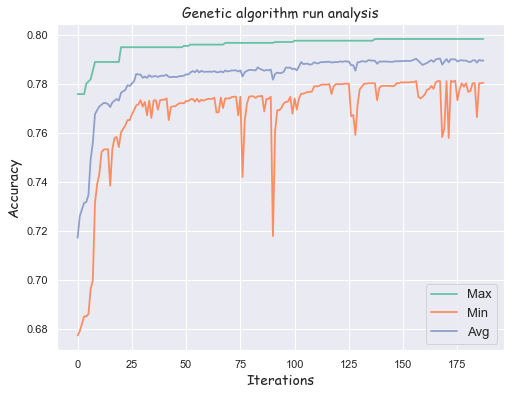

In [17]:
pld = pd.DataFrame(GA.runData, columns=['Max','Min','Avg'])

# style
fig = plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
palette = plt.get_cmap('Set2')
csfont = {'fontname':'Comic Sans MS', 'fontsize': 14}

# multiple line plot
for i, column in enumerate(pld):
    plt.plot(range(pld.shape[0]), pld[column], marker='', color=palette(i), lw=1.8, label=column)
 

plt.legend(fontsize = 13) 
plt.title("Genetic algorithm run analysis", **csfont)
plt.xlabel("Iterations", **csfont)
plt.ylabel("Accuracy", **csfont)
plt.show()

In [18]:
GA.bestChromosome

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0])